# YOLOv8 People Detector

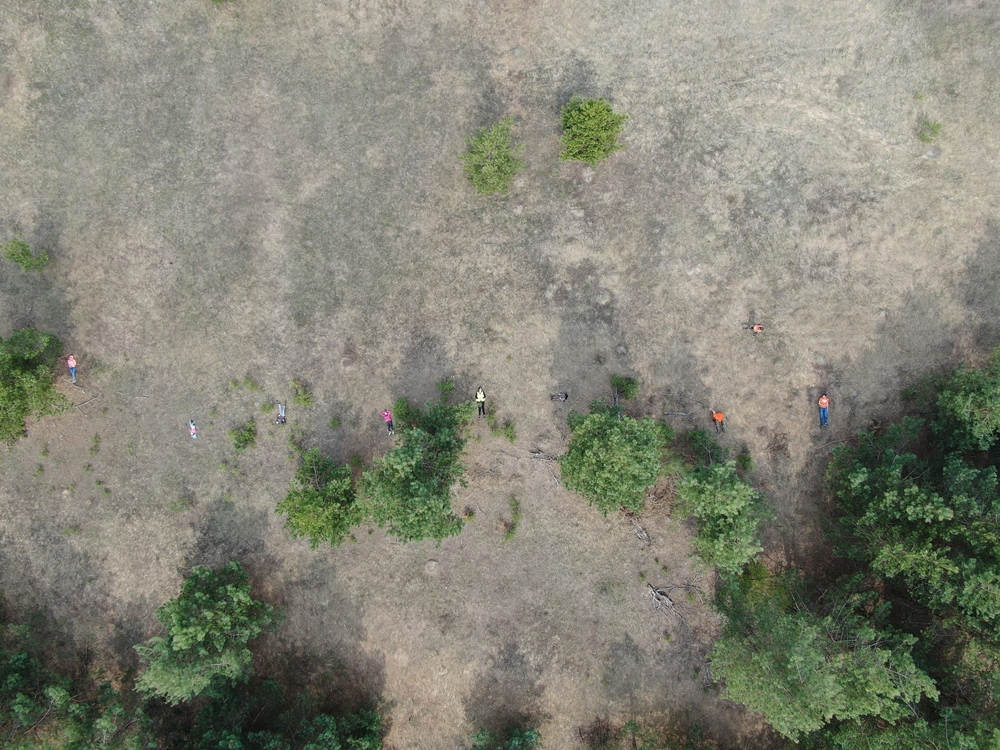

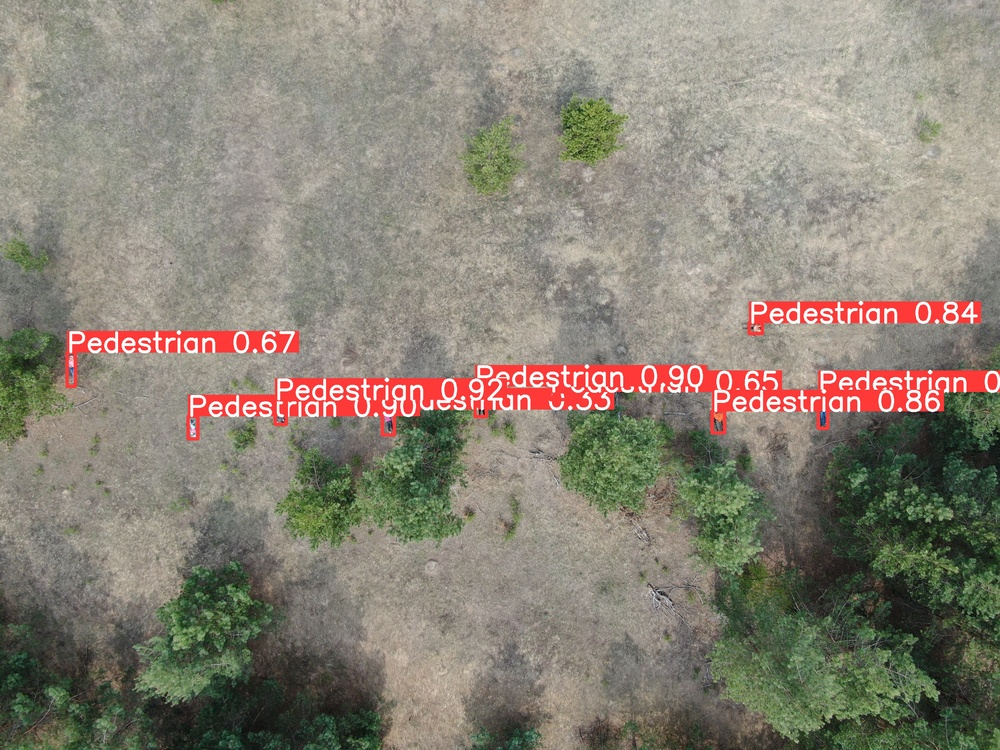

In this project, we will create a people detector model using the YOLOv8 algorithm based on Pytorch. This model can be useful in a variety of scenarios: from monitoring and controlling the number of people in a specific area, to finding potentially lost people in a forest. In this specific project, we focus on the latter case.

We will work with the summer_tambov_2019 dataset available at https://cloud.mail.ru/public/2k53/2bJVwYSa7. This dataset is a compilation of images captured by drone at a height of approximately 50 meters. Some of these images contain one or more people in random spots, while some others contain only wild landscape. Every image has a corresponding annotations file, and txt files have been included specifying the number of images to be used for training, testing, and validation.

Our process starts at this point. The txt files mentioned above specify which images should be used for either train, test, or validation. However, the folder containing the images themselves are not sorted. This means that we're supposed to write some code that helps us to sort the images.

Let's write the following code for sorting the images and their annotations files into 3 different folders (train, test, and validation):

In [ ]:
import os


# defining a function for creating the 'train', 'test', and 'validation' folders

def new_folders(new_fold_name, parent_fold_name):
    directory = new_fold_name
    parent = parent_fold_name
    path = os.path.join(parent, directory)
    os.mkdir(path)
    
    
# defining the parent path and new folder names

parent_path = ".\\Dataset\\summer_tambov_2019"
train_fold = "Train"
test_fold = "Test"
val_fold = "Validation"


# using the function

traindir = new_folders(train_fold, parent_path)
testdir = new_folders(test_fold, parent_path)
valdir = new_folders(val_fold, parent_path)

Now that we have our new folders, we will use the txt files that indicate which images should be used for training, testing, and validation in order to sort our files into the new folders. 

To do this, first we need to create lists of the files we're supposed to move. We will create Numpy arrays in order to compare the elements and create our lists.

In [ ]:
import os
import numpy as np

# transforming image and annotation files into arrays without extension

img_path = (".\\Dataset\\summer_tambov_2019\\JPEGImages")
ann_path = (".\\Dataset\\summer_tambov_2019\\Annotations")

def file_array(path):
     path_list = os.listdir(path)
     no_ext = [os.path.splitext(file)[0] for file in path_list]
     to_arr = np.loadtxt(no_ext, dtype=int)
     return to_arr

imgdir = file_array(img_path)
anndir = file_array(ann_path)


# transforming txt files into arrays

testfile = ".\\Dataset\\summer_tambov_2019\\ImageSets\\Main\\test.txt" 
trainfile = ".\\Dataset\\summer_tambov_2019\\ImageSets\\Main\\train.txt"
valfile = ".\\Dataset\\summer_tambov_2019\\ImageSets\\Main\\val.txt"

testfile_array = np.loadtxt(testfile, dtype=int)
trainfile_array = np.loadtxt(trainfile, dtype=int)
valfile_array = np.loadtxt(valfile, dtype=int)


# defining a function for comparing txt and file arrays and creating our lists

def move_to_list(file_array, file_dir):
     moveto_list = []
     for e in np.nditer(file_array):
          for i in np.nditer(file_dir):
               if i == e:
                    moveto_list.append(str(i))
     return moveto_list
               
# using the function for images and annotations files 

img_testlist = move_to_list(testfile_array, imgdir)
img_trainlist = move_to_list(trainfile_array, imgdir)
img_vallist = move_to_list(valfile_array, imgdir)

ann_testlist = move_to_list(testfile_array, anndir)
ann_trainlist = move_to_list(trainfile_array, anndir)
ann_vallist = move_to_list(valfile_array, anndir)

At this point we have our lists, so now we need to iterate over each element in the lists and compare it with the name of each image and annotations file. After doing this, we will have sorted our files into their respective folders.

In [ ]:
import os
import glob
import shutil

# defining functions for moving images and annotation files to the new respective folders 
#(*IT WILL BE IMPORTANT TO VERIFY THE INDEX PLACE WHERE THE FILE NAME IS MENTIONED*)
# *in the case of images, the name is specified in the [71:75], and in the [72:76] for the annotation files*

list_of_imgfiles = sorted(filter(os.path.isfile, glob.glob(img_path + '/**/*', recursive=True)))
list_of_annfiles = sorted(filter(os.path.isfile, glob.glob(ann_path + '/**/*', recursive=True)))

def moving_imgs_to_folder(list_of_img_files, img_files_to_move, dest_folder):
     for i in list_of_img_files:
          for l in img_files_to_move:
               if i[71:75] == l:
                    shutil.copy(i, dest_folder)

def moving_anns_to_folder(list_of_ann_files, ann_files_to_move, dest_folder):
     for i in list_of_ann_files:
          for l in ann_files_to_move:
               if i[72:76] == l:
                    shutil.copy(i, dest_folder)

                    
# moving to Test folder

moving_imgs_to_folder(list_of_imgfiles, img_testlist, testdir)
moving_anns_to_folder(list_of_annfiles, ann_testlist, testdir)


# moving to Train folder

moving_imgs_to_folder(list_of_imgfiles, img_trainlist, traindir)
moving_anns_to_folder(list_of_annfiles, ann_trainlist, traindir)


# moving to Validation folder

moving_imgs_to_folder(list_of_imgfiles, img_vallist, valdir)
moving_anns_to_folder(list_of_annfiles, ann_vallist, valdir)

Our files are sorted now, but we still need to do some changes. YOLOv8 reads the annotations files in txt format during training. However, the annotation files in this dataset are in xml format. So, we will need to convert these files in order to be readable for the YOLO algorithm.

To do this, we will use the following code:

In [ ]:
import glob
import os
import pickle
import xml.etree.ElementTree as ET
from os import listdir, getcwd
from os.path import join


# difining path and class data mentioned in the xml annotations files

dirs = [".\\Dataset\\summer_tambov_2019\\Train", ".\\Dataset\\summer_tambov_2019\\Test"] 
classes = ['Pedestrian']


# defining a function for counting the number of images inside folder

def getImagesInDir(dir_path):
    image_list = []
    for filename in glob.glob(dir_path + '/*.jpg'):
        image_list.append(filename)

    return image_list


# defining a function for converting box format

def convert(size, box):
    dw = 1./(size[0])
    dh = 1./(size[1])
    x = (box[0] + box[1])/2.0 - 1
    y = (box[2] + box[3])/2.0 - 1
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)


# defining function for converting the annotations files

def convert_annotation(dir_path, output_path, image_path):
    basename = os.path.basename(image_path)
    basename_no_ext = os.path.splitext(basename)[0]

    in_file = open(dir_path + '/' + basename_no_ext + '.xml')
    out_file = open(output_path + basename_no_ext + '.txt', 'w')
    tree = ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
        bb = convert((w,h), b)
        out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')

cwd = getcwd()


# using the functions for converting xml to txt annotations files

for dir_path in dirs:
    full_dir_path = cwd + '/' + dir_path
    output_path = full_dir_path +'/yolo/'

    if not os.path.exists(output_path):
        os.makedirs(output_path)

    image_paths = getImagesInDir(full_dir_path)
    list_file = open(full_dir_path + '.txt', 'w')

    for image_path in image_paths:
        list_file.write(image_path + '\n')
        convert_annotation(full_dir_path, output_path, image_path)
    list_file.close()

    print("Finished processing: " + dir_path)

Our annotations files are now in txt format and ready for the training step. However, there's a last step before we can complete our data preprocessing. The .train method of YOLOv8 reads a file in yaml format which specifies the paths to train and test files, in addition to the number and names of classes for prediction. This means that this yaml file is key for training our model.

We will create this yaml file using the following code:

In [ ]:
import yaml
import re


# defining the content of our yaml file

file_content = """
    train = path
    val = path

    nc = 1
    names = ['Pedestrian']
    """

# defining a function to convert txt to yaml

def convert_txt_to_yaml(content):
    config_dict = {}
    
    # splitting the lines 
    lines = file_content.splitlines()
    section_title=None
    for line in lines:
        if line=='\n':
            continue
        elif re.match('.*end$', line):
            # defining end of section
            section_title=None
        elif re.match('.*Section\s+.*', line):
            # defining start of section
            match_obj =  re.match(".*Section\s+(.*)", line)
            section_title=match_obj.groups()[0]
            config_dict[section_title] = {}
        elif section_title and re.match(".*{}_.*\s+=.*".format(section_title), line):
            match_obj =  re.match(".*{}_(.*)\s+=(.*)".format(section_title), line)            
            config_dict[section_title][match_obj.groups()[0]] = match_obj.groups()[1]
    return yaml.dump(config_dict)


# using the function to create the file

data_yaml = convert_txt_to_yaml(file_content)


# saving the new file

with open(r'train_test_data.yaml', 'w') as file:
    documents = yaml.dump(data_yaml, file)

Now that we have our yaml file, our data preprocessing step is finally complete. It means that we can start training our model. YOLOv8 provides us with a range of models which we can choose depending on our tasks. These models vary from the "nano" size (yolov8n) to the "huge" size (yolov8x). For this specific project, we will use the "medium" size (yolov8m) since our task manages object detection for one class only.

The code for defining and training the model is the following:

In [ ]:
# installing the package and importing the model

!pip install ultralytics
from ultralytics import YOLO


# defining model (we chose the "medium" size)

model = YOLO("yolov8m.pt")


# starting the training process on 10 epochs, providing our yaml file and using 640 for the image size

model.train(data="train_test_data.yaml", epochs=10, imgsz=640)

After training for 10 epochs, the model with the best prediction results will be saved on the "runs\detect\train(n)\weights" path, usually inside a "train" folder with the highest number. This train folder will also include evaluation metrics such as confusion matrixes and curves.

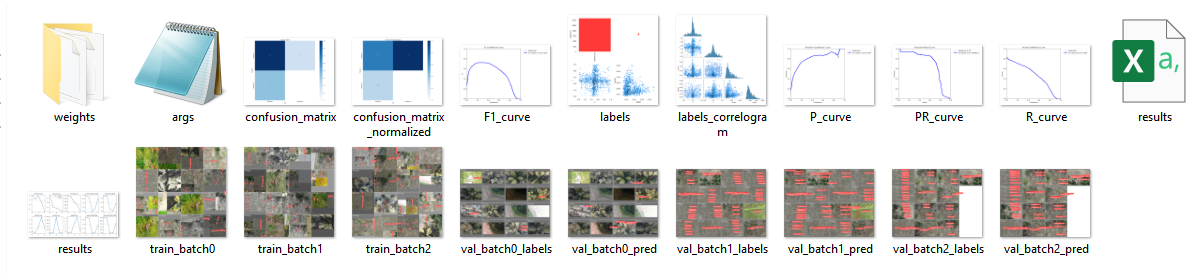

As mentioned above, we can choose the best predicting model from the "weights" folder and use it for testing on our validation set.
To do this, we will define a function to iterate over the whole validation set and generate predictions over each image.

The code is the following:

In [ ]:
import glob


# defining the paths to the best predicting model and the folder with images for validation

path_to_best = "runs/detect/train14/weights/best.pt"
val_path = "../Scripts/Dataset/summer_tambov_2019/Validation"


# defining a function for testing new images and saving in new folder "val_results_folder"

def testing(result_folder, data_path):
    # creating folder to store results
    test_fold_count = len(glob.glob('runs/detect/*'))
    print(f"{test_fold_count}")
    val_results_folder = f"testing_{test_fold_count+1}"
    print(val_results_folder)
    # command for testing
    !yolo task=detect mode=predict model="runs/detect/train14/weights/best.pt" source= "../Scripts/Dataset/summer_tambov_2019/Validation" name= test_folder
    return val_results_folder

testing(path_to_best, val_path)

After this process is completed, the results were stored in the "val_results_folder". Now we can examine these results and see how accurate our model is

Original image:

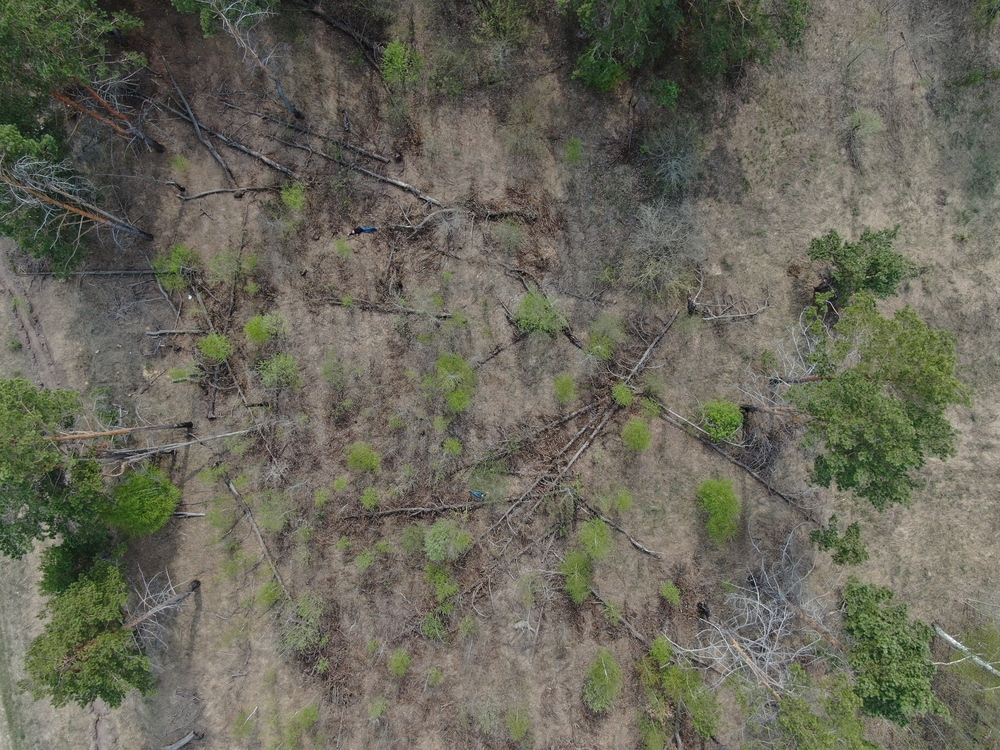


Prediction:

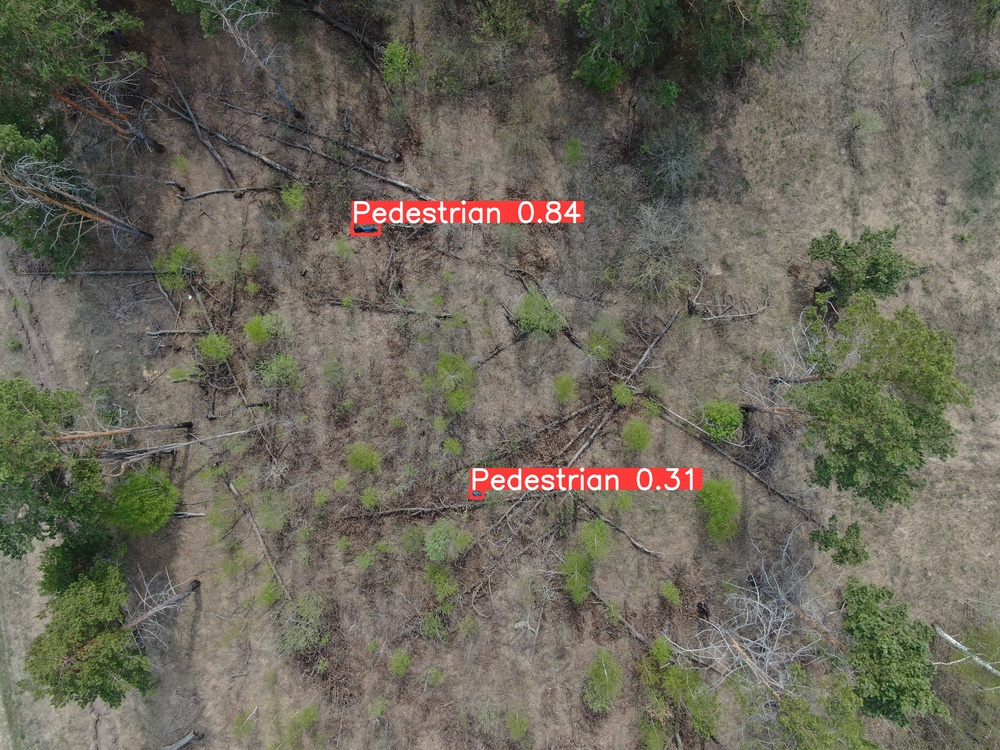

We can see that our model is pretty accurate. It was able to clearly identify these two people and highlight them in the landscape. However we will see now that the model struggles identifying people in certain conditions such as dark background or dark clothes.

Original image:

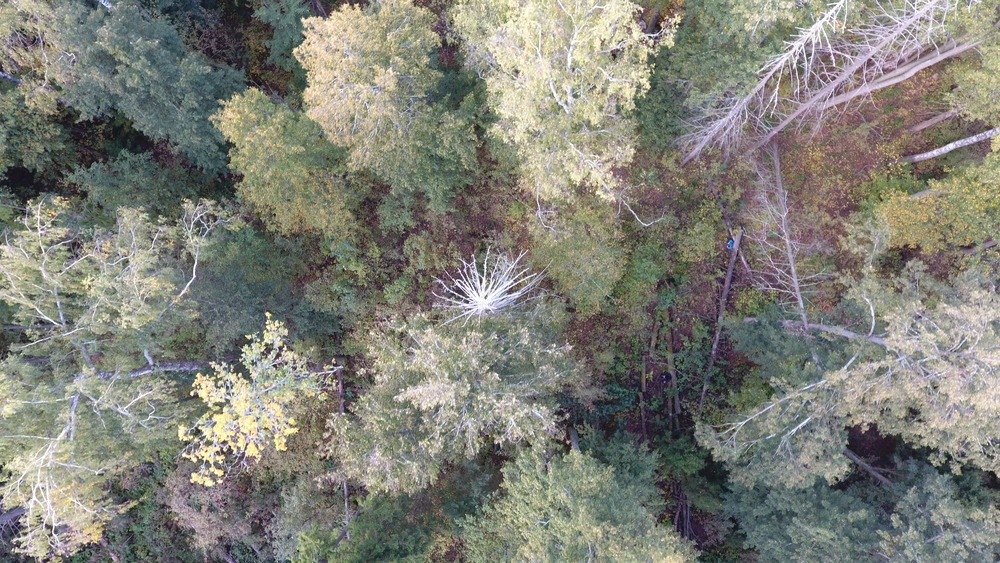


Prediction:

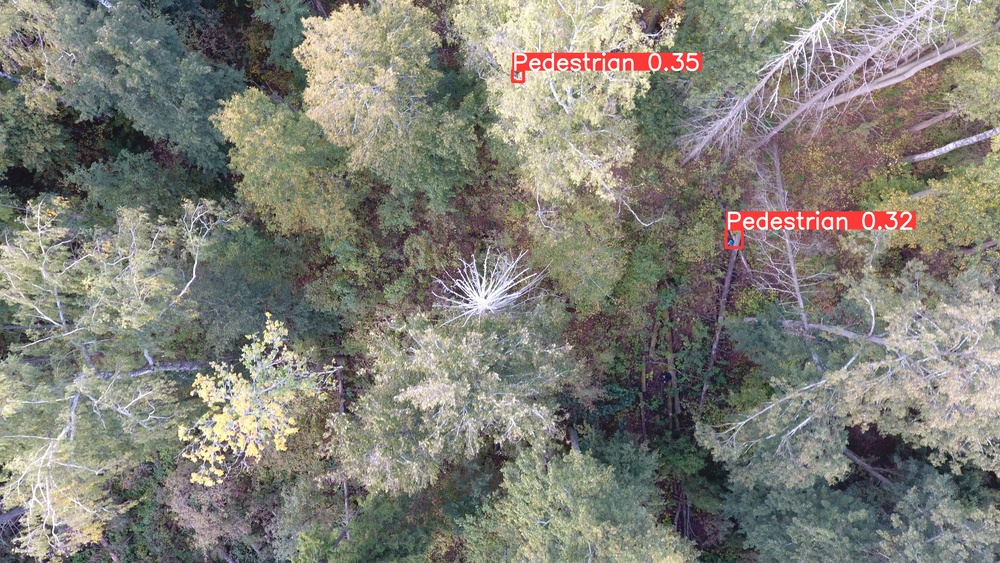

In this case, the model was able to predict the person in blue, but it misspredicted a shade in the tree as a person and it ignored the person in black. This can mean that the model struggles predicting the correct class in a dark environment (like a forest) where colours are usually similar and shady.

In the next images, we can see a similar issue. When the background is too dark due to night time or lack of sunlight, the model generated wrong predictions.

Original image:

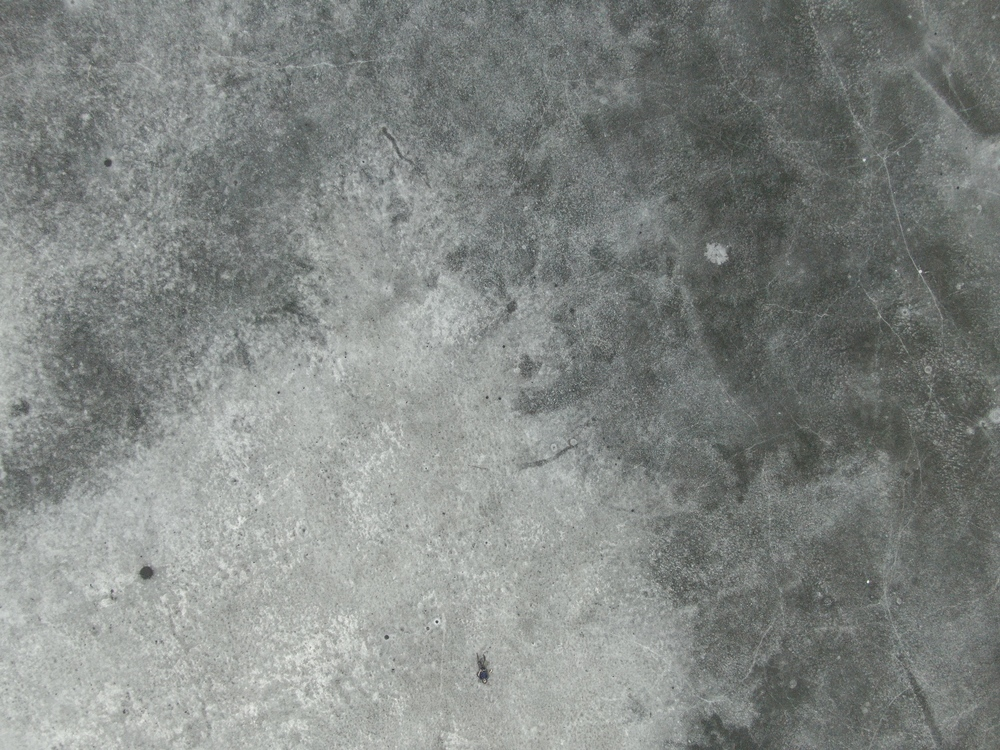


Prediction:

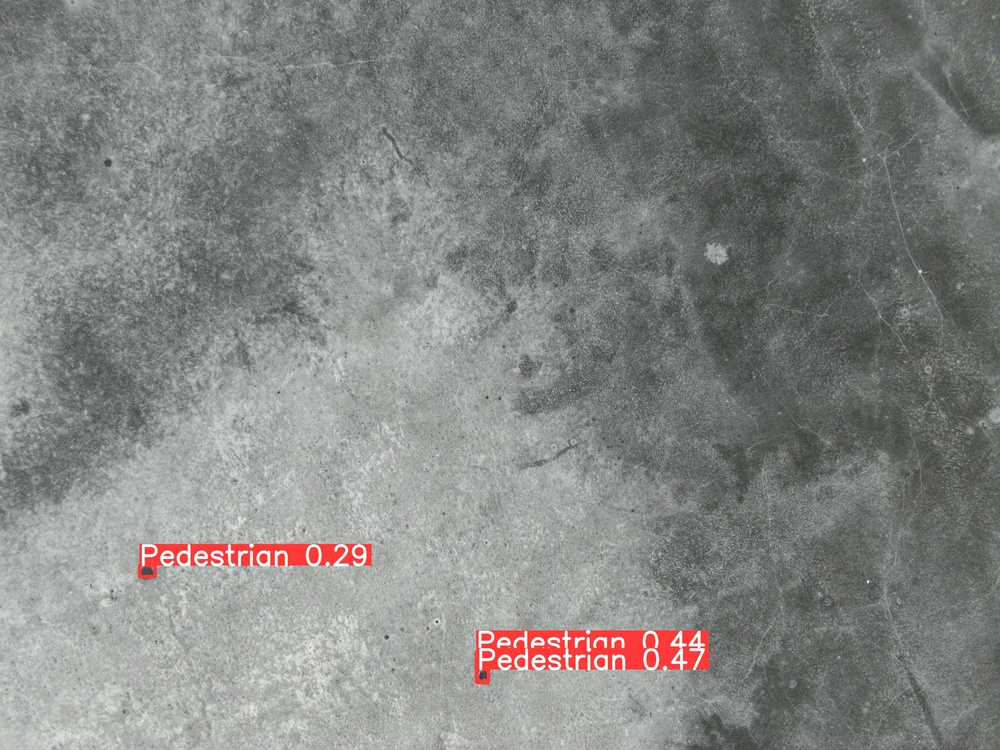

In this case, the model predicted the person as two separate people, and it also misspredicted the rounded shade as a person. We can see that the image is dark due to lack of light, so the model had problems to separate shapes and colours. 

Regardless of this, the images' quality was high enough for a model of this size to be able to detect little or dark details despite the images backgrounds, so we can conclude that image quality wasn't (and shouldn't be) a factor.

Having said that, the issue might have occured mainly because of the functions used for changing file formats. Since a big ammount of files with different annotations were rewritten in a general way, some crucial information may have got lost, making the model detect "noise" in some images. It is adviced to do a more thorough analysis to such functions and their respective outputs. 